I finally started reading a series of books during my break featuring a certain wizard named Harry Potter. As I progressed through the series, I noticed the page count getting longer and the books getting heavier. While recounting this to a friend who had also read the series, she noted that she felt the writing style of the books seemed to grow as much as the thickness. While the earlier books (particularly the first) seemed to be written for a younger audience with simpler sentences and descriptions, she said, this seemed to get more complex in the later books as Harry also comes of age. I have heard this sentiment confirmed with other readers, and began to wonder whether it would be possible to quantify the writing complexity and measure whether there is a significant difference as the series progress. This [notebook](https://github.com/d10genes/boy_who_lived) is my attempt to quantify it.  

To quantify the complexity, I look at the following metrics: average word length and sentence length, word frequency within the text, word frequency based on external sources, and the average syntactic complexity of sentences.

The testing to determine the difference between books is largely inspired by the recent presentation ["Statistics for Hackers"](https://speakerdeck.com/jakevdp/statistics-for-hackers) by Jake VanderPlas, where he introduces simulations, label shuffling, bootstrapping and cross validation as intuitive alternatives to classical statistical approaches. The two methods that I mainly use here are permutation testing ('label shuffling') and the bootstrap. I also used this as a chance to try out the [spaCy](https://spacy.io) NLP library, which bills itself as a "library for industrial-strength natural language processing in Python and Cython."

As a fair warning to those whoe want to run this notebook for themselves, some of the simulations take a really long time to run (~2  hrs), but joblib caches the results after the first run. Obtaining the text is left as an exercise to the reader.

From here on out, the words will be much sparser than the code.

# Import, load/clean/parse text
See `utils.py` for cleaning and parsing details.

In [1]:
%%javascript
var csc = IPython.keyboard_manager.command_shortcuts
csc.add_shortcut('Ctrl-k','ipython.move-selected-cell-up')
csc.add_shortcut('Ctrl-j','ipython.move-selected-cell-down')
csc.add_shortcut('Shift-m','ipython.merge-selected-cell-with-cell-after')

<IPython.core.display.Javascript object>

In [2]:
from project_imports import *
import utils as ut; reload(ut);
%matplotlib inline

cachedir = 'cache/'
memory = Memory(cachedir=cachedir, verbose=0)

In [3]:
bksall = ut.BookSeries(7)

The starting point for spaCy is a parsing function that parses, tags and detects entities all in one go. This unfortunately takes quite a bit of time to load (but is at least a [known issue](https://github.com/honnibal/spaCy/issues/219)).

In [4]:
from spacy.en import English
from spacy.parts_of_speech import ADJ, NAMES as pos_names

%time nlp = English()

CPU times: user 54.7 s, sys: 1.93 s, total: 56.6 s
Wall time: 58.5 s


In [64]:
%%time
bktksall = {i: nlp(bktxt, tag=True, parse=True, entity=True)
            for i, bktxt in bksall.txts.items()}

CPU times: user 1min 30s, sys: 3.16 s, total: 1min 33s
Wall time: 1min 34s


I'll be writing a bunch of functions that take a list of tokens and returns a list of processed strings, numbers, etc. The following higher order functions are to facilitate applying these `[Token] -> [a]` functions to the entire Harry Potter series, returning a dataframe that keeps track of which book the processed value in a given row came from.

In [6]:
def tobooks(f: '(toks, int) -> DataFrame', bks=bktksall) -> DataFrame:
    """Apply a function `f` to all the tokens in each book,
    putting the results into a DataFrame column, and adding
    a column to indicate each book.
    """
    return pd.concat([f(v, i) for i, v in bks.items()])

def booker(f: 'toks -> [str]') -> '(toks, int) -> DataFrame':
    @wraps(f)
    def tobookdf(toks, bknum):
        res = f(toks)
        if np.ndim(res) == 1:
            df = DataFrame(f(toks), columns=['Val'])
        else:
            df = res
        df['Book'] = bknum
        return df
    return tobookdf
    
over_books = z.comp(partial(tobooks, bks=bktksall), booker)

As an example, a function that takes a stream of tokens and returns the first 2 words that are adjectives,

In [65]:
fst_2_nouns = lambda xs: list(it.islice((x.orth_ for x in xs
                                         if x.pos == ADJ), 2))

can be applied to each book in the series as:

In [8]:
over_books(fst_2_nouns)

       Val  Book
0    proud     1
1   normal     1
0    first     2
1    early     2
0  unusual     3
1     many     3
0     many     4
1      its     4
0  hottest     5
1    close     5
0      his     6
1     long     6
0      few     7
1   narrow     7

# Search for increasing complexity
## Average word and sentence length

A first simple search would be to see if the average length of the words or sentences increases throughout the series.

In [9]:
spanlen = lambda span: len([wd for wd in span if len(wd) > 1])
sent_lensf = lambda parsed: [spanlen(sent) for sent in parsed.sents]
wd_lensf = lambda parsed: [len(tok) for tok in parsed if len(tok) > 1]

In [10]:
wd_lensb = over_books(wd_lensf)
sent_lensb = over_books(sent_lensf)

In [11]:
def wd_sent_lens():
    def agg_lens(lns):
        return (lns
              .groupby('Book')['Val'].agg(['mean', 'median', 'std'])
              .rename(columns=str.capitalize))

    wd_len = agg_lens(wd_lensb)
    sent_len = agg_lens(sent_lensb)
    
    lens = {'Sentence_length': sent_len, 'Word_length': wd_len}
    return pd.concat(lens.values(), axis=1, keys=lens.keys()).round(2)

wsls = wd_sent_lens()
wsls

     Word_length              Sentence_length              
            Mean Median   Std            Mean Median    Std
Book                                                       
1           4.31      4  1.97           19.34     15  15.63
2           4.42      4  2.07           20.56     16  16.73
3           4.45      4  2.12           18.94     15  16.51
4           4.43      4  2.11           20.47     16  17.24
5           4.46      4  2.15           23.57     18  20.81
6           4.48      4  2.21           22.87     18  19.52
7           4.43      4  2.14           21.57     17  18.07

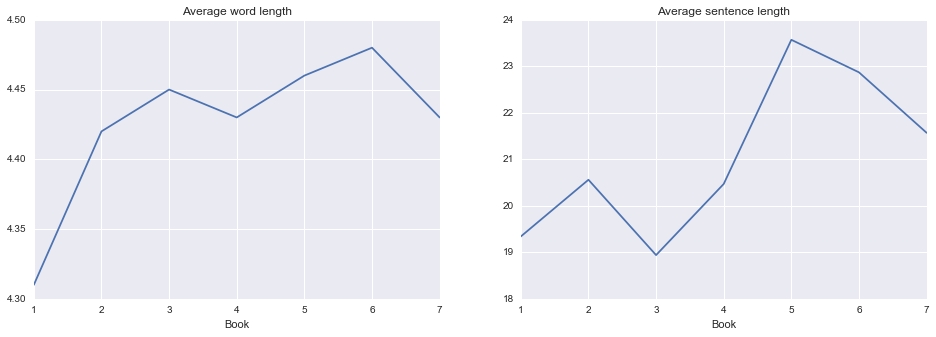

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
wsls.Word_length['Mean'].plot(title='Average word length')
plt.subplot(1, 2, 2)
wsls.Sentence_length['Mean'].plot(title='Average sentence length');

There does appear to be an increasing trend for both average word and sentence length difference between the books, though the scale of the difference looks small compared to the standard deviations within each book.

One way to gauge the likelihood that the average word length difference between, say, books 1 and 2 is due to chance would be to   shuffle the labels a bunch of times, and each time calculate the difference in average word length. (See Jake VanderPlas' [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers) talk and [Tim Hesterberg's article](http://arxiv.org/abs/1411.5279) covering permutation tests for an explanation). This shuffling lets us simulate the distribution for the word length differences--if we see that the actual difference in word length between books one and two fits in around the middle of this simulated distribution, then there's a good likelihood that the increase in average word length is small enough is simply due to chance. If the actual word length difference falls to the far upper edge of the distribution, we can be confident in rejecting the idea that the difference is due to chance, which many would take as sufficient evidence of an increasing complexity throughout the series.

In [13]:
def sim_diff_(xs, N, aggfunc=np.mean, p=.5):
    labs = nr.binomial(1, p, N)  # cheap shuffling approximation
    g1 = aggfunc(xs[labs == 1])
    g2 = aggfunc(xs[labs == 0])
    return g2 - g1


@memory.cache
def sim_diff(xs, n1, aggfunc=np.mean, nsims=10, n_jobs=1):
    N = len(xs)
    p = n1 / N
    xs = np.array(xs)
    f = delayed(sim_diff_)
    gen = (f(xs, N, aggfunc=aggfunc, p=p) for _ in range(nsims))
    return Series(Parallel(n_jobs=n_jobs)(gen))


def plot_perm_diffs(samps, actual=None, bka=2, bkb=1,
                    subplt=1, xlabel=None):
    t = ('Simulated and actual difference between books {bka} and {bkb}'
         '\nPermutation pvalue: {pv:.3%}; N={N:,.0f}'
          .format(bka=bka, bkb=bkb,
                  pv=ut.pvalue(actual, samps),N=len(samps)))
    plt.subplot(1, 2, subplt, title=t)
    samps.hist(bins=50)
    plt.vlines(actual, *plt.ylim())
    plt.legend(['Actual\ndifference'], loc=2)
    if xlabel is not None:
        plt.xlabel(xlabel)

In [14]:
wd_lensb23 = wd_lensb.query('Book == [2, 3]')
perm_wd_23 = sim_diff(wd_lensb23.Val, wd_lensb23.Book
                      .value_counts(normalize=0)[2],
                      nsims=10000, n_jobs=-1)

CPU times: user 16 ms, sys: 12.9 ms, total: 28.9 ms
Wall time: 32.8 ms


In [15]:
wd_lensb12 = wd_lensb.query('Book == [1, 2]')
perm_wd_12 = sim_diff(wd_lensb12.Val, (wd_lensb12.Book
                                       .value_counts(normalize=0)[1]),
                      nsims=10000, n_jobs=-1)

CPU times: user 14.9 ms, sys: 6.94 ms, total: 21.9 ms
Wall time: 24.8 ms


As the following histogram of simulated word length differences shows, the difference is quite significant in the word lengths, despite what the large standard deviations first led me to believe. The trendline above shows an pronounced jump between books 1 & 2 which is reflected in the smallest possible p-value, but the permutation sampling shows that the jump between 2 and 3 is also significant.

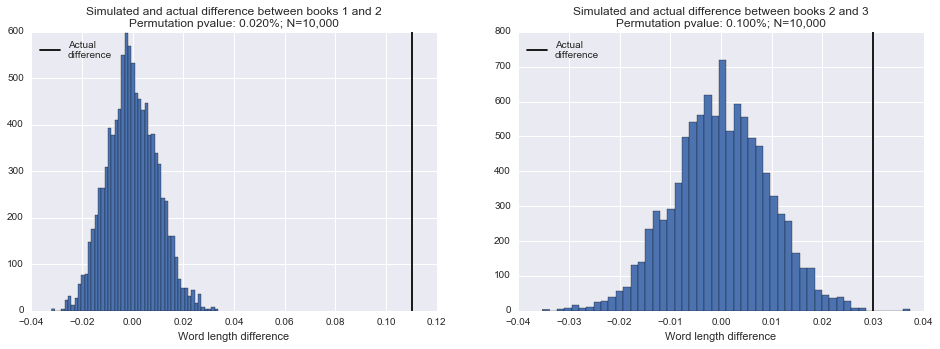

In [16]:
plt.figure(figsize=(16, 5))
dw12 = wsls.Word_length.Mean[2] - wsls.Word_length.Mean[1]
plot_perm_diffs(perm_wd_12, actual=dw12, bka=1, bkb=2,
                subplt=1, xlabel='Word length difference')

dw23 = wsls.Word_length.Mean[3] - wsls.Word_length.Mean[2]
plot_perm_diffs(perm_wd_23, actual=dw23, bka=2, bkb=3,
                subplt=2, xlabel='Word length difference')

The earlier trendline for *sentence* lengths is more ambiguous. While the word length immediately jumps following *The Sorcerer's Stone* and continues to increase in all but 2 cases, the sentence length bounces around a lot more. But there does seem to be a significant difference between the first four and the last three, which we can also test for.

In [17]:
sent_lensb['Part'] = (sent_lensb.Book <= 4).map({True: '1-4',
                                                 False: '5-7'})
μ_ab = sent_lensb.groupby('Part').Val.mean()

n1 = sent_lensb.Part.value_counts(normalize=0)['1-4']
%time perm_sent_ab = sim_diff(sent_lensb.Val, n1, nsims=10000, n_jobs=-1)
del n1
sent_lens12 = sent_lensb.query('Book == [1, 2]')
perm_sent_12 = sim_diff(sent_lens12.Val, (sent_lens12.Book
                                          .value_counts(normalize=0)[1]),
                        nsims=100000, n_jobs=-1)

CPU times: user 7.54 ms, sys: 7.6 ms, total: 15.1 ms
Wall time: 18 ms
CPU times: user 6.32 ms, sys: 8.63 ms, total: 15 ms
Wall time: 24.2 ms


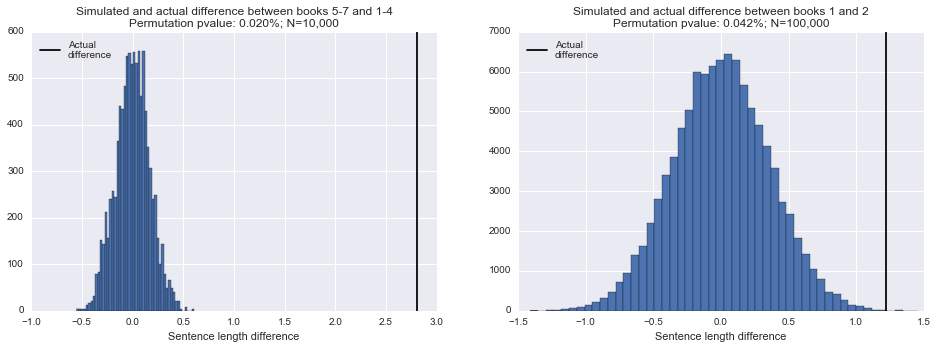

In [18]:
plt.figure(figsize=(16, 5))
dsab = μ_ab.ix['5-7'] - μ_ab.ix['1-4']
plot_perm_diffs(perm_sent_ab, actual=dsab, bka='5-7', bkb='1-4'
                subplt=1, xlabel='Sentence length difference')

ds12 = wsls.Sentence_length.Mean[2] - wsls.Sentence_length.Mean[1]
plot_perm_diffs(perm_sent_12, actual=ds12, bka=1, bkb=2,
                subplt=2, xlabel='Sentence length difference')

Here we see that the difference between books 1 & 2 is very significant, though not as much as the enormous difference between the first and second parts (as defined by 1-4 and 5-7). Thus we can, with reasonable confidence, reject the notion that the increase in word length and sentence length through the series is a statistical artifact that ocurred by chance. 

## Word complexity by frequency

In addition to measuring the increase in average word/sentence length, it could be more insightful to measure the frequency of rarer words. My hypothesis was that even complex language is still largely composed of shorter, commoner words, highlighted by rarer, more complex words. A way to test this could be to somehow get a measure of the frequency of just the rarer words by counting, for example, what percentage of the words only appear once.

In [ ]:
with open('src/stops.txt', 'r') as f:
    stops = set(l for l in f.read().splitlines()
                if l and not l.startswith('#'))

In [19]:
def reg_words(parsed):
    "Non-capitalized words > 3 chars long that aren't stopwords"
    wds = [tok.orth_ for tok in parsed]
    return [w for w in wds if len(w) > 3
            and (w.lower() not in stops) and not w[0].isupper()]

def wd_freqs(parsed):
    vcs = Series(Counter(reg_words(parsed))).sort_values(ascending=False)
    return vcs

In [20]:
uncwds = over_books(wd_freqs).reset_index(drop=1)

The folllowing shows the relative word frequency distribution. The first two numbers in the first column indicate that for book one, words appearing only 1 time account for 45.2% of all the word occurences, while words appearing twice account for 16.9%. If anything, it appears that the share of rare words (those appearing only once or twice) *decreases* with each book, rather than increases.

In [21]:
k = 10
wdfreq = DataFrame({bknum: gdf.Val.value_counts(normalize=1)[:k]
            for bknum, gdf in uncwds.groupby(['Book'])})
wdfreq = (wdfreq * 100).round(1)
wdfreq.columns.name, wdfreq.index.name = 'Book', 'Word_freq'
wdfreq

Book          1     2     3     4     5     6     7
Word_freq                                          
1          45.2  46.8  45.5  42.2  39.3  44.1  42.5
2          16.9  16.7  16.6  16.2  16.3  16.2  16.6
3           9.1   8.9   9.0   8.9   9.3   9.6   9.3
4           5.8   5.2   5.4   5.8   6.3   5.7   5.8
5           3.6   4.4   4.0   4.2   4.2   3.8   4.2
6           2.5   3.1   2.8   3.4   3.4   2.9   2.8
7           2.5   2.1   2.4   2.1   2.4   2.2   2.2
8           1.5   1.7   1.6   2.0   2.0   1.7   1.9
9           1.3   1.2   1.5   1.6   1.6   1.4   1.6
10          1.5   1.2   1.4   1.2   1.2   1.2   1.3

The cumulative share of words appearing 10 times or less also doesn't seem to indicate an increasing share of uncommon words, and if anything points to uncommon words being used more in the first three books, and decreasing for the last four. (The following graph should be interpreted to say that, for example, 90% of the words in the first book are those that appear fewer than 11 times, while 86% of the words in book 5 occur fewer than 11 times).

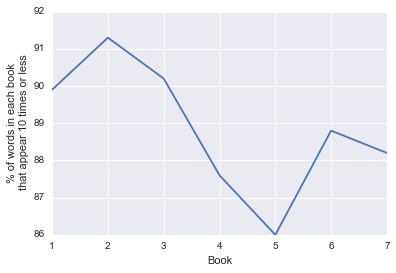

In [22]:
wdfreq.apply(mc('cumsum')).ix[10].plot()
plt.ylabel('% of words in each book\n that appear 10 times or less');

## Word complexity by English language frequency

The frequency counting above, however, only counts words that are rare within the context of this series. Fortunately, spaCy provides a log-probability score for each parsed word, based on its frequency in external corpora. These numbers will be less than zero, such that a more negative score indicates that a word is less common in English usage outside of Harry Potter. "Low probability," "low likelihood" and "less common" are terms I'll use to describe words with low log-probability scores.

In [23]:
probs = lambda x: [tok.prob for tok in x if tok.is_lower]
prob_books = over_books(probs)

In [24]:
def percentile(q: float) -> "[float] -> int":
    def f(s):
        return np.percentile(s, q)
    f.__name__ = 'perc_{}'.format(q)
    return f

def show_freq(bookstats):
    probstats = (bookstats.groupby('Book').Val
                 .agg(['mean', 'std', 'median',
                       percentile(5), percentile(25)])
                .rename(columns=str.capitalize))
    (probstats[['Perc_5', 'Perc_25', 'Median', 'Mean']]
     .plot(title='Word Frequency'))
    plt.xticks(range(1, 8));
    return probstats

          Mean       Std    Median     Perc_5   Perc_25
Book                                                   
1    -7.471484  2.980987 -6.783067 -13.336818 -9.371277
2    -7.640089  3.144749 -6.887355 -13.817394 -9.679132
3    -7.613900  3.134172 -6.873591 -13.743346 -9.599585
4    -7.577784  3.093336 -6.834407 -13.580673 -9.578794
5    -7.614340  3.130544 -6.867525 -13.771987 -9.599279
6    -7.537434  3.078741 -6.798487 -13.601532 -9.514395
7    -7.579748  3.135474 -6.798487 -13.580077 -9.651070

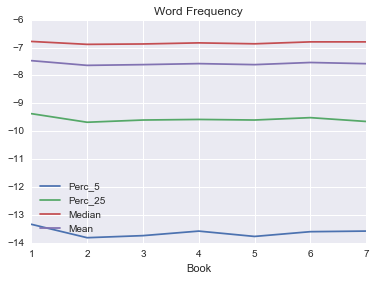

In [25]:
show_freq(prob_books)

The most drastic difference is in the frequency of the 95th percentile between first and second books. The graph shows that a typical word in the 95th percentile has a log probability of -13.3 in the first book and -13.8 in the second (this is about the difference between the words *frogs* and *lopsided*). The drop doesn't look that drastic, and there doesn't seem to be a discernable overall trend, either.

Out of curiosity, it could be helpful to dig into what the probabilities look like for the first couple hundred least likely words.

In [26]:
probs1 = probs(bktksall[1])
probs2 = probs(bktksall[2])
# probs12 = probs1 + probs2

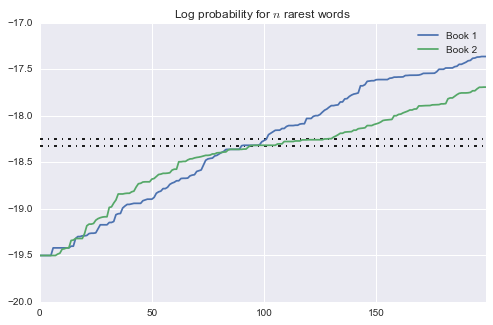

In [27]:
def show_unc_word_trend():
    n = 200
    s1 = Series(probs1).sort_values(ascending=True).reset_index(drop=1)
    s1[s1 < -12][:n].plot()
    s2 = Series(probs2).sort_values(ascending=True).reset_index(drop=1)
    s2[s2 < -12][:n].plot(title='Log probability for $n$ rarest words')
    plt.legend(['Book 1', 'Book 2'])
    
plt.figure(figsize=(8, 5))
show_unc_word_trend()
plt.hlines([-18.25, -18.32], *plt.xlim(), linestyles='dashdot');

Starting from the least common words, it looks like the part of the reason Book 2's words are less frequent is due to a few streaks of words that have log probabilities indicated at the dashed lines. The repetition of certain uncommon words in the story line could lead us to classify some text as more complex than we should. A solution would be to run the same plots on the probabilities of *unique* words in the texts.

In [28]:
def get_prob_id(toks) -> 'DataFrame[Prob, Id]':
    return DataFrame([(tok.prob, tok.orth) for tok in toks
                      if tok.is_lower], columns=['Prob', 'Id'])
 
def unique_probs(toks):
    "Like `probs`, but drop duplicate words"
    df = get_prob_id(toks)
    return df.drop_duplicates('Id').Prob.tolist()

uprob_books = over_books(unique_probs)

           Mean       Std     Median     Perc_5    Perc_25
Book                                                      
1    -12.039409  2.557880 -11.861153 -16.382277 -13.759457
2    -12.348383  2.571819 -12.214560 -16.684626 -14.141342
3    -12.384750  2.560132 -12.241310 -16.728664 -14.131651
4    -12.669902  2.514527 -12.581882 -17.000200 -14.349375
5    -12.857596  2.548120 -12.777979 -17.288639 -14.549596
6    -12.677524  2.509364 -12.598336 -17.009187 -14.349295
7    -12.765511  2.502108 -12.709429 -17.044932 -14.439640

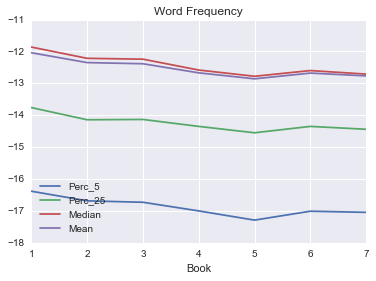

In [29]:
ufreq = show_freq(uprob_books)
ufreq

Here, the trend towards more complex words is much more pronounced, and looks as if it continues throughout the whole series, with book 5 having disproportionately many more complex words. As anyone who's read the series can tell, Book 5 (*Order of the Phoenix*) also stands out as being disproportionately longer in page numbers, as confirmed by the wordcount:

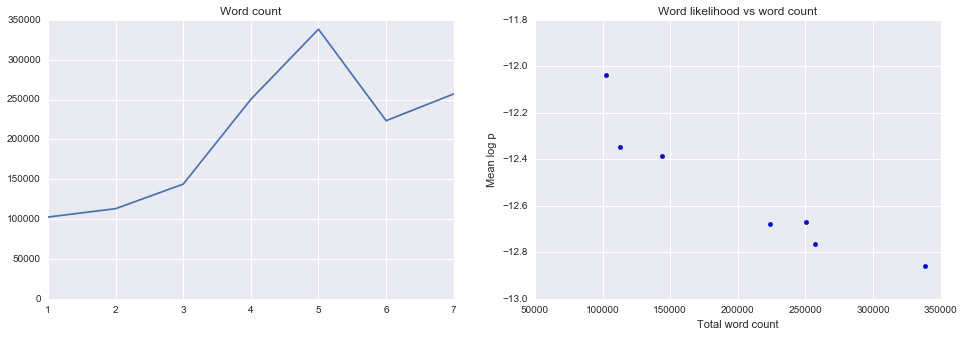

In [30]:
plt.figure(figsize=(16, 5))
wc = Series(z.valmap(len, bktksall))
plt.subplot(1, 2, 1)
wc.plot(title='Word count'); plt.ylim(0, None);
plt.subplot(1, 2, 2)
plt.scatter(wc, ufreq.Mean)
plt.title('Word likelihood vs word count')
plt.ylabel('Mean log p'); plt.xlabel('Total word count');

...which could lead us to wonder whether the increasing complexity in word choice is simply an artifact of the length of the books (if the text were generated randomly from the same distribution, we would expect longer texts to include a greater number of unique and rarer words).

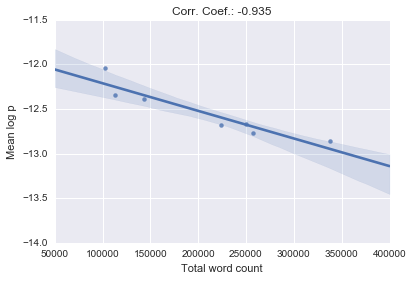

In [31]:
def plot_corrcoef(x=None, y=None, data=None):
    sns.regplot(x=x, y=y, data=data, order=1)
    plt.title('Corr. Coef.: {:.3f}'
              .format(stats.pearsonr(data[x], data[y])[0]))
    plt.ylabel('Mean log p')
    plt.xlabel('Total word count');
    
plot_corrcoef(x='Word_count', y='Mean', data=ufreq.assign(Word_count=wc))

Indeed, the relationship between typical word probability appears to have a quite [log] linear relationship with word count. I'm not sure what relationship is to be expected, but it looks like it would be worthwhile to try and correct for document length in determining word complexity.

###Aside: growth trend for unique words

Before digging into this correction, here is what the growth pattern looks like for unique words, sampling and shuffling several times. The cumulative count of unique words resembles a log curve, and the new word rate resembles an exponential decay curve (at least to my eyes). This is roughly the pattern that I would expect; after seeing the first few hundred words, it will become more and more likely that you've already seen any given new word that comes along in the text, so the growth rate will rapidly taper off as you've seen more words.

In [32]:
def simgrowth(toks, nsims=20, window=200):
    def simgrowth_():
        s = set()
        l = []
        tks = map(prop('orth'), toks)
        nr.shuffle(tks)
        for w in tks:
            s.add(w)
            l.append(len(s))
        sl = Series(l)
        nl = sl.values
        rate = Series(pd.rolling_mean(nl[1:] - nl[:-1], window)
                     ).dropna()
        return sl, rate
    
    return [simgrowth_() for _ in range(nsims)]

ls = simgrowth(bktksall[1], nsims=10)

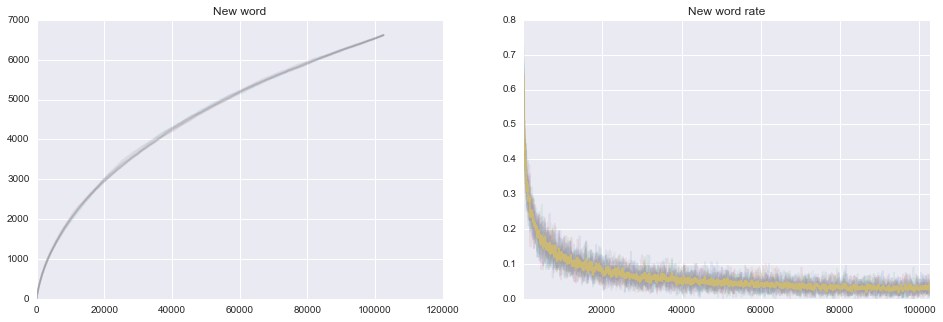

In [74]:
plt.figure(figsize=(16, 5))
for l, rm in ls:
    plt.subplot(1, 2, 1)
    plt.title('New word')
    plt.plot(l, alpha=.1, )
    
    plt.subplot(1, 2, 2)
    plt.title('New word rate')
    rm.plot(alpha=.1)
    
μ_rm = pd.concat(map(itg(1), ls), axis=1).mean(axis=1)
μ_rm.plot(alpha=1);

### Probability of unique words: correcting for varying word counts
####Simulate word distributions
For each booklength $L$, I'll be repeatedly sampling $L$ words without replacement from the combined text of all the books, and then finding the average unique word probability of each sample. This should give an estimate of what the average word count should be for each book given the length of each book, assuming they were all drawing from the same source of words. 

In [34]:
def sim(df, seed=None, aggfunc=None, size=None, rep=False):
    dd = (df.sample(n=size, replace=rep, random_state=seed
                   ).drop_duplicates('Id').Prob)
    # with replacement, the distribution gets biased
    # towards more low-probability words
    return aggfunc(dd)

In [35]:
def sim_gen_text(worddist=5, sizebook=1, nsims=10000,
                 aggfunc=np.median, n_jobs=0, vb=False, rep=False):
    pt = print if vb else (lambda *x, **_: None)
    sizedf = get_prob_id(bktksall[sizebook])
    size = len(sizedf)
    if worddist == 8:
        df = pd.concat([get_prob_id(bktksall[i]) for i in range(1, 8)])
    else:
        df = get_prob_id(bktksall[worddist])
    
    mu = aggfunc(df.drop_duplicates('Id').Prob)
    pt(mu)
    if (len(df) == size) and not rep:
        return [mu for _ in range(nsims)]
        
    if len(df) < size:
        raise ValueError("Can't sample with replacement"
                         " from smaller distribution")
    f = delayed(sim) if n_jobs else sim
    gen = (f(df, seed=seed, aggfunc=aggfunc, size=size, rep=rep)
           for seed in range(nsims))
    if n_jobs:
        pt('Running {} jobs...'.format(n_jobs), end=' ')
        ret = Parallel(n_jobs=n_jobs)(gen)
    else:
        ret = list(gen)
    pt('Done.')
    sys.stdout.flush()
    return ret 

In [36]:
@memory.cache
def get_gen_prob_text(nsims=10000, n_jobs=-1, worddist=5, rep=False):
    gens_mus = {
        booknum: sim_gen_text(worddist=worddist, sizebook=booknum,
                              nsims=nsims, aggfunc=np.mean,
                              n_jobs=n_jobs, rep=rep)
        for booknum in range(1, 8)
    }
    d = DataFrame(gens_mus)
    return d

def join_sim_act(simdf_):
    cs = ['Val', 'Book', 'Source']
    simdf = simdf_.copy()
    simdf.columns.name = 'Book'
    simdf = (simdf.stack().sort_index(level='Book').reset_index(drop=0)
             .rename(columns={0: 'Val'}).drop('level_0', axis=1))
    simdf['Source'] = 'Simulation'
    dboth = (simdf[cs].append(uprob_books.assign(Source='Actual')[cs])
             .sort_values(['Book', 'Source'], ascending=True))
    return dboth, simdf

In [37]:
%time simdf_ = get_gen_prob_text(nsims=10000, worddist=8,
                                 n_jobs=-1, rep=False)
dboth, simdf = join_sim_act(simdf_)
bothagg = dboth.groupby(['Source', 'Book',]).mean()
bothagg.unstack('Source')

CPU times: user 4.53 ms, sys: 12.6 ms, total: 17.2 ms
Wall time: 19.8 ms


              Val           
Source     Actual Simulation
Book                        
1      -12.039409 -12.318187
2      -12.348383 -12.362340
3      -12.384750 -12.473922
4      -12.669902 -12.755102
5      -12.857596 -12.888716
6      -12.677524 -12.700427
7      -12.765511 -12.769392

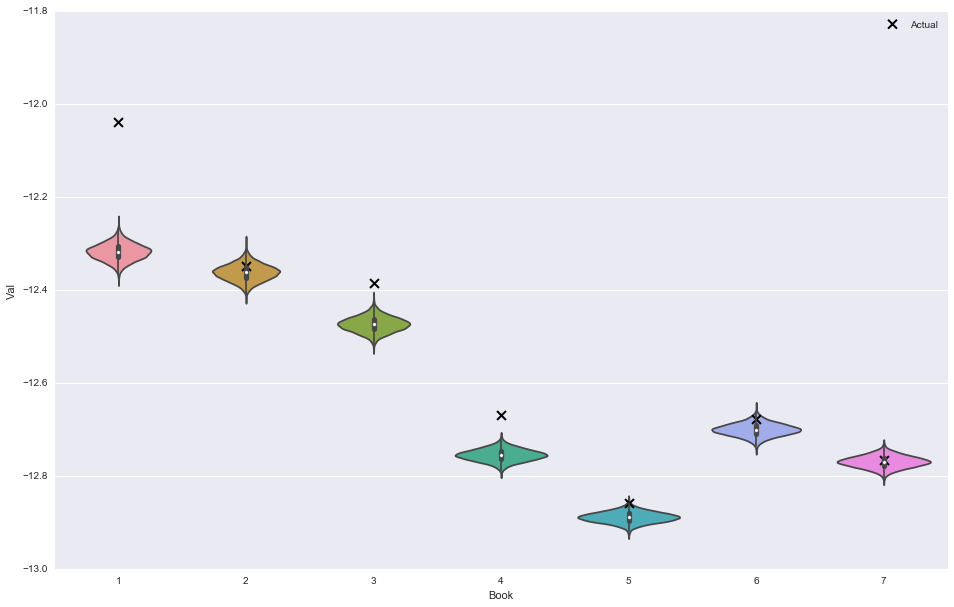

In [38]:
plt.figure(figsize=(16, 10))
pbothagg = ut.mod_axis((bothagg.ix['Actual'].copy()
                        .rename(columns={'Val': 'Actual'})),
                       z.operator.add(-1))
plt.scatter([], [], s=80, c='k', marker='x', linewidth=2)
plt.legend(['Actual']);
sns.violinplot('Book', 'Val', data=simdf)
plt.scatter(pbothagg.index, pbothagg.Actual, s=80, c='k',
            marker='x', linewidth=2);

Barring some subtle errors in my simulation code (which would not surprise me at all), the violin plot above says that the actual average word probability for books 2, 5, 6 and 7 are roughly what one would expect if words were drawn at random from the whole series, based solely on the length of the book. Measuring word complexity as having a low probability, this could lead one to say that the word complexity of the first book is way below what it should be given its length, as well as the 3rd and 4th to a lesser extent, with 5, 6 and 7 increasingly approaching the average. This seems to be the best evidence so far of the writing complexity increasing as Harry Potter's education progresses.

The trend in increasing complexity is perhaps clearer when plotting this difference in simulated and actual average probability:

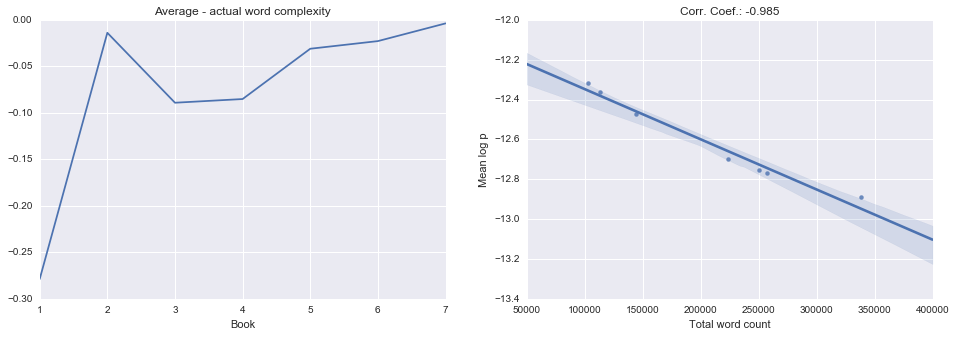

In [75]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
(bothagg.unstack('Source')['Val'].eval('Simulation - Actual')
 .plot(title='Average - actual word complexity'))
plt.subplot(1, 2, 2)
plot_corrcoef(x='Word_count', y='Mean',
              data=simdf.groupby(['Book']).mean()
              .rename(columns={'Val': 'Mean'}).assign(Word_count=wc))

To the right, we also see that at least the simulated values are much better estimated by a linear word count predictor (negative correlation coefficient of .985 for the simulated vs .935 for the actual averages plotted earlier), giving me a bit more confidence in my sampling procedure.

## Sentence structure complexity

There are different ways to measure the complexity of a sentence based on the syntactical structure, as determined by spaCy's parser. The parse tree of the first sentence of the sentence is parsed below.

In [40]:
import pygraphviz as pgv

def build_graph(s, add_edge=ut.add_edge):
    G = pgv.AGraph(directed=True)
    reprdct = ut.dedupe_wrd_repr(s)
    
    def build_graph_(tok, i=0):
        for c in tok.children:
            add_edge(tok, c, G, reprdct=reprdct)
            build_graph_(c, i=i + 2)
        return G
    return build_graph_(s.root)


def show_graph(g):
    g.draw("file.png", prog='dot')
    return Image(filename="file.png") 


s = next(bktksall[1].sents)
G = build_graph(s)
Gi = build_graph(s, add_edge=ut.add_int_edge)

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.


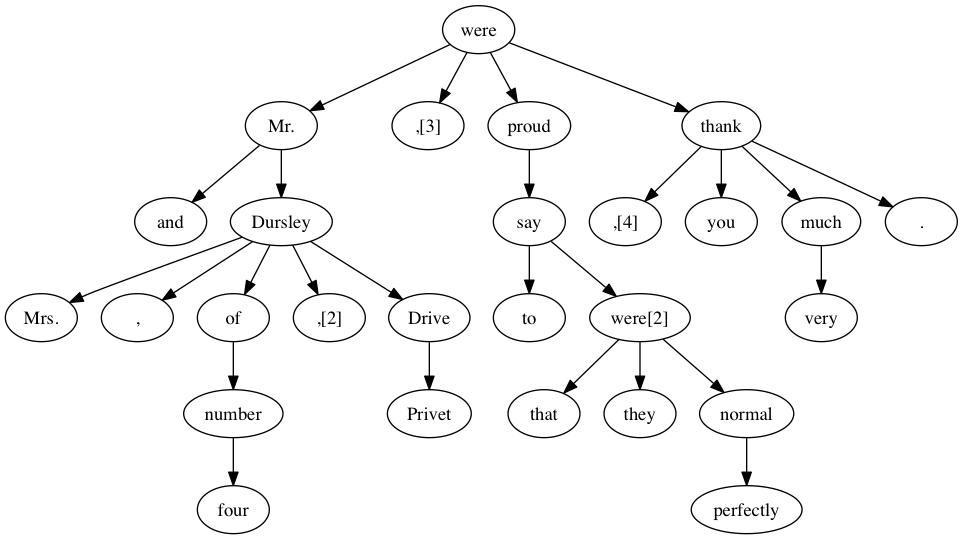

In [79]:
print(s)
show_graph(G)

The two features to compare across books that came to mind looking at this structure are the total height of the whole tree, and the depth of the nodes, averaged for each sentence. While I used permutation tests to analyze the other metrics above, here I'll run bootstrap simulations of the syntax tree depths, and average the difference between books over the simulated values, just to mix things up.

In [43]:
def tree_depths(s, senti=None):
    def tree_depths_(tok, i=1, vb=False,):
        return [(i, senti)] + [t for c in tok.children
                      for t in tree_depths_(c, i=i + 1, vb=vb)]
    return tree_depths_(s.root, i=1)


def sent_depth_bk(toks):
    return DataFrame([(depth, i) for i, s in 
                      enumerate(toks.sents)
                      for depth, senti in tree_depths(s, senti=i)],
                    columns=['Depth', 'Sentnum'])


sent_depths = over_books(sent_depth_bk).reset_index(drop=1)

In [44]:
sgb = (sent_depths.groupby(['Book']).Depth
       .agg(['mean', 'median', 'max', 'idxmax'])
       .rename(columns=str.capitalize))
sgb

          Mean  Median  Max  Idxmax
Book                               
1     3.401772       3   16   37927
2     3.450535       3   16   84547
3     3.373326       3   18  155121
4     3.486288       3   21  282986
5     3.670590       3   20  632677
6     3.602477       3   19  691921
7     3.570338       3   18  909435

In [45]:
def sim_depth(s, seed=None, size=None, aggfunc=None):
    return aggfunc(s.sample(n=size, replace=True, random_state=seed))


@memory.cache
def bootstrap_depths(df, by='Book', col=None, aggfunc=np.mean,
                     nsims=10, size=1000, n_jobs=1):
    genmkr = lambda s: (delayed(sim_depth)(s, seed=seed,
                                           aggfunc=aggfunc, size=size)
                        for seed in range(nsims))
    df = DataFrame({bknum: Parallel(n_jobs=n_jobs)(genmkr(gbs))
                    for bknum, gbs in df.groupby(by)[col]} )
    return df

def piv(df):
    df.columns.name = by
    return (df.unstack().reset_index(drop=0).drop('level_1', axis=1)
            .rename(columns={0: 'Val'}))

In [46]:
bootdepths = bootstrap_depths(sent_depths, by='Book', col='Depth',
                              nsims=10000, n_jobs=-1)

CPU times: user 86.4 ms, sys: 9.96 ms, total: 96.3 ms
Wall time: 104 ms


Here are the bootstrapped average depths of each word by book for comparison. There is a visible increase in the sentence depth in the last three books.

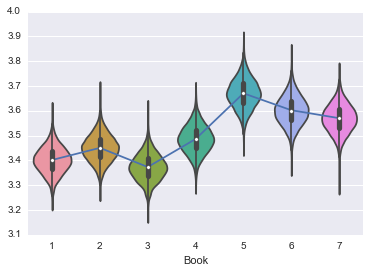

In [47]:
ut.mod_axis(sgb, z.operator.add(-1)).Mean.plot()
sns.violinplot(data=bootdepths);

In [48]:
def plot_bt_diffs(samps, bka, bkb, subplt=1):
    diff = samps[bka] - samps[bkb]
    t51 = ('Average depth: Book {bka} - book {bkb}'
           ' \n(0 > difference in {perc:.2%} of examples)'
           .format(bka=bka, bkb=bkb, perc=(0 > diff).mean()))
    plt.subplot(1, 2, subplt, title=t51)
    diff.hist(bins=50)
    plt.vlines(0, *plt.ylim())

A difference of 0 between books 1 and 5 doesn't overlap much (if at all) with the distribution of the bootstrapped samples, giving us reason to believe that the difference in syntactical complexity is significant at least between these books. This contrasts with the difference between books 1 and 2--while the the average difference is about .05 levels, the simulations make a hypothesis of 0 difference look plausible:

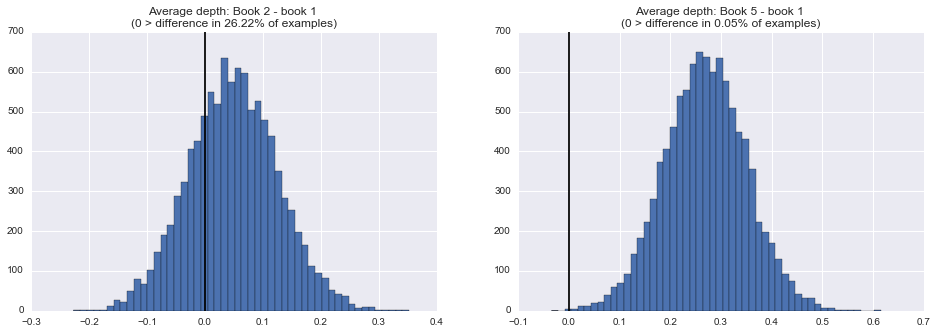

In [49]:
plt.figure(figsize=(16, 5))
plot_bt_diffs(bootdepths, 2, 1, subplt=1)
plot_bt_diffs(bootdepths, 5, 1, subplt=2)

### Height

One more metric I would like to look at is the average 'height' of the sentences by books. While I previously looked at the average depth of each word in the syntax tree, this will just take the *maximum* depth of each sentence.

In [50]:
maxdepth = (sent_depths.groupby(['Book', 'Sentnum']).Depth.max()
        .reset_index(drop=0))
sgbs = (maxdepth.groupby(['Book']).Depth
        .agg(['mean', 'median', 'max'])
        .rename(columns=str.capitalize)
       )
sgbs

          Mean  Median  Max
Book                       
1     4.936863       5   16
2     5.105529       5   16
3     4.854756       5   18
4     5.079722       5   21
5     5.285099       5   20
6     5.212841       5   19
7     5.219668       5   18

Here again we see a bit of variation in the average sentence height by each book, but it's not obvious whether these differences are significant. Time for the bootstrap again!

In [51]:
bootheights = bootstrap_depths(maxdepth, by='Book', col='Depth',
                               nsims=100000, n_jobs=-1, size=1000)

CPU times: user 10.5 ms, sys: 13.1 ms, total: 23.6 ms
Wall time: 48.9 ms


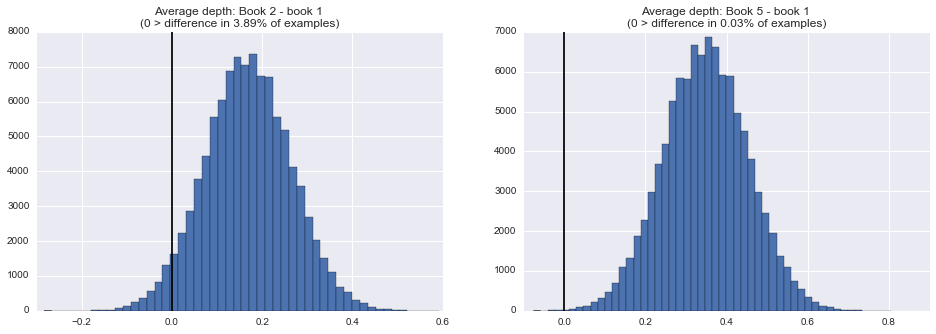

In [52]:
plt.figure(figsize=(16, 5))
plot_bt_diffs(bootheights, 2, 1, subplt=1)
plot_bt_diffs(bootheights, 5, 1, subplt=2)

In the case of measuring the difference in average sentence *heights* between the books, we have much more confidence that the difference in books 5 and 1 *and* between 2 and 1 were not due to chance.

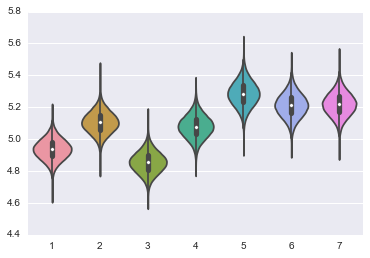

In [53]:
sns.violinplot(data=bootheights);

## Part of Speech trends

Since spaCy automatically labels parts of speech, a last dimension I wanted to check was whether there is a change in POS usage across the books.

In [54]:
def pos_counts(toks):
    return Series(w.pos for w in toks).value_counts(normalize=0)

In [55]:
pos_stacked = (over_books(pos_counts)
               .assign(POS=lambda x: x.index.map(pos_names.get))
              .reset_index(drop=1))
pos_stacked[:3]

     Val  Book    POS
0  27049     1   NOUN
1  19042     1  PUNCT
2  18814     1   VERB

I plotted below, in each box, the trendline for the part of speech frequency (I believe the correct POS abbreviation mapping is described [here](https://universaldependencies.github.io/docs/en/pos/all.html)). The first box shows, for example, that nouns go from being about 26.4% of the words in book 1, to accounting for less 26% of the words in the final book. While the trends are interesting, I don't see anything pop out at me other than the number (NUM) and symbol (SYM) frequencies, which are too small for me to draw any conclusions from. I'm also not sure what conclusions one could draw simply based on part of speech counts--does more complex writing tend to have more verbs or adjectives?

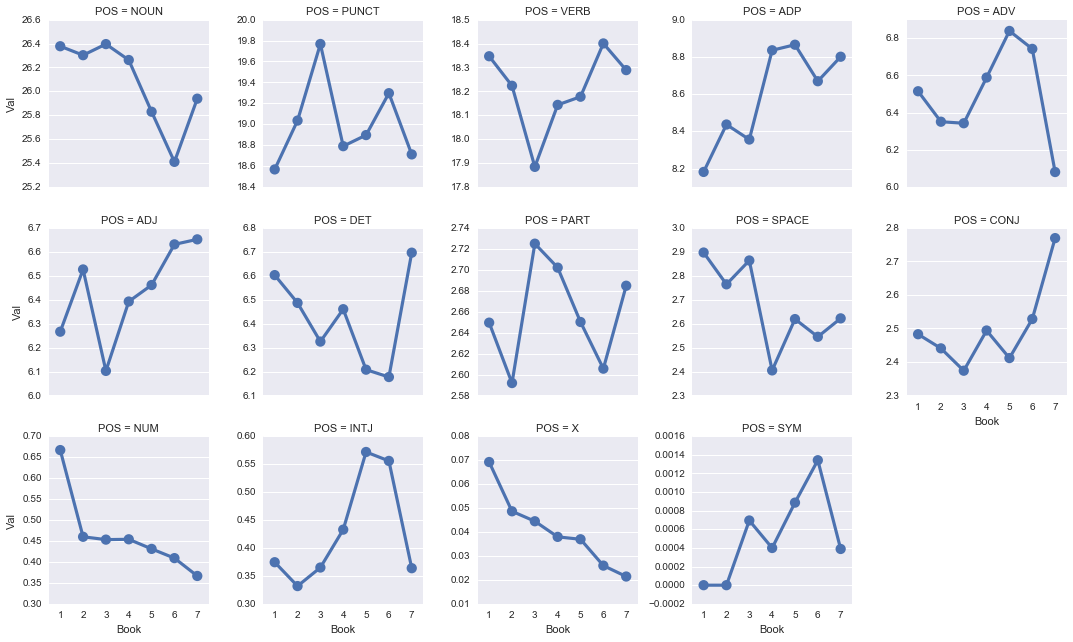

In [56]:
pos = pos_stacked.set_index(['POS', 'Book', ]).unstack().fillna(0)
pos_norm = (pos / pos.sum() * 100).stack().reset_index(drop=0)
pos_order = (pos_norm.groupby('POS').Val.median()
             .sort_values(ascending=0).index)
g = (sns.FacetGrid(pos_norm, col="POS", col_wrap=5, size=3,
                   sharey=False, col_order=pos_order)
     .map(sns.pointplot, 'Book', 'Val'))

# Conclusion

This analysis has presented several possible metrics for measuring reading complexity across the Harry Potter series. Measuring the average word length and sentence length revealed statistically significant increases as the series progressed. While looking at the share of repeated words didn't appear to show a major trend, there did seem to be a discernible increase in uncommon word usage, defined by how often words appear in external bodies of English text. While the increasing book length accounted for part of the increase in uncommon words, attempting to correct for the book length by only averaging unique words showed a surprisingly large gap between the average probability of words in book 1 versus the rest. That is, the first book had a much larger share of common (and, as some might argue, more basic) words.

I also examined the average depth of the syntax trees of the sentences in each book. The average depth and, to a greater extent, the maximum depth, showed an increase throughout the series. While the difference between each of the consecutive book wasn't enormous, the difference between the first and fifth was quite large.

While not every angle described an increasing complexity, such as the share of part of speech tags, there does seem to be enough evidence that these metrics do point to an increasing complexity throughout the series.

## Bonus: fun unrelated stats

#### Longest words, ordered by frequency

In [57]:
longs = (Series([tok.orth_ for bk in bktksall.values()
                for tok in bk if len(tok.orth_) > 18])
         .value_counts(normalize=0))
for word, cnt in longs.items():
    print('{}: {}'.format(cnt, word))

46: Who-Must-Not-Be-Named
5: uncharacteristically
2: great-granddaughter
2: WHO-MUST-NOT-BE-NAMED
1: Third-Law-states-that-the-antidote-for-a-blended-poison-will-be-equal-to-more-than-the-sum-of-the-antidotes-for-each-of-the-separate-components
1: great-great-great-grandson
1: like-to-see-you-try-it
1: AAAAAAAAAAAAAARRRRRRRRRRRRGGGGGHHHHH
1: you-did-break-school-rules
1: home-for-the-summer
1: you-have-already-lost-your-House-ten-points-do-not-make-matters-worse-for-yourself
1: don't-think-you're-being-very-sensitive
1: joke-about-things-like-that
1: his-problem-not-yours


#### Longest unhyphenated words

In [58]:
Series([tok.orth_ for bk in bktksall.values()
        for tok in bk if len(tok.orth_) > 15
        and '-' not in tok.orth_]).value_counts(normalize=0)

enthusiastically                        33
counterclockwise                         9
incomprehensible                         8
conversationally                         6
uncharacteristically                     5
indistinguishable                        4
unenthusiastically                       3
uncomprehendingly                        2
conspiratorially                         2
overenthusiastic                         2
counterarguments                         2
underrepresented                         1
Rematerialization                        1
uncharacteristic                         1
Incomprehensible                         1
Interdepartmental                        1
AAAAAAAAAAAAAARRRRRRRRRRRRGGGGGHHHHH     1
inconsequentially                        1
responsibilities                         1
incontrovertible                         1
lightheartedness                         1
Transfigurations                         1
disproportionate                         1
NOOOOOOOOOO

#### Tallest sentence in the series

All of them were shivering with a combination of cold and nerves as they filed along the staff table and came to a halt in a line facing the rest of the school - all of them except the smallest of the lot, a boy with mousy hair, who was wrapped in what Harry recognized as Hagrid's moleskin overcoat.


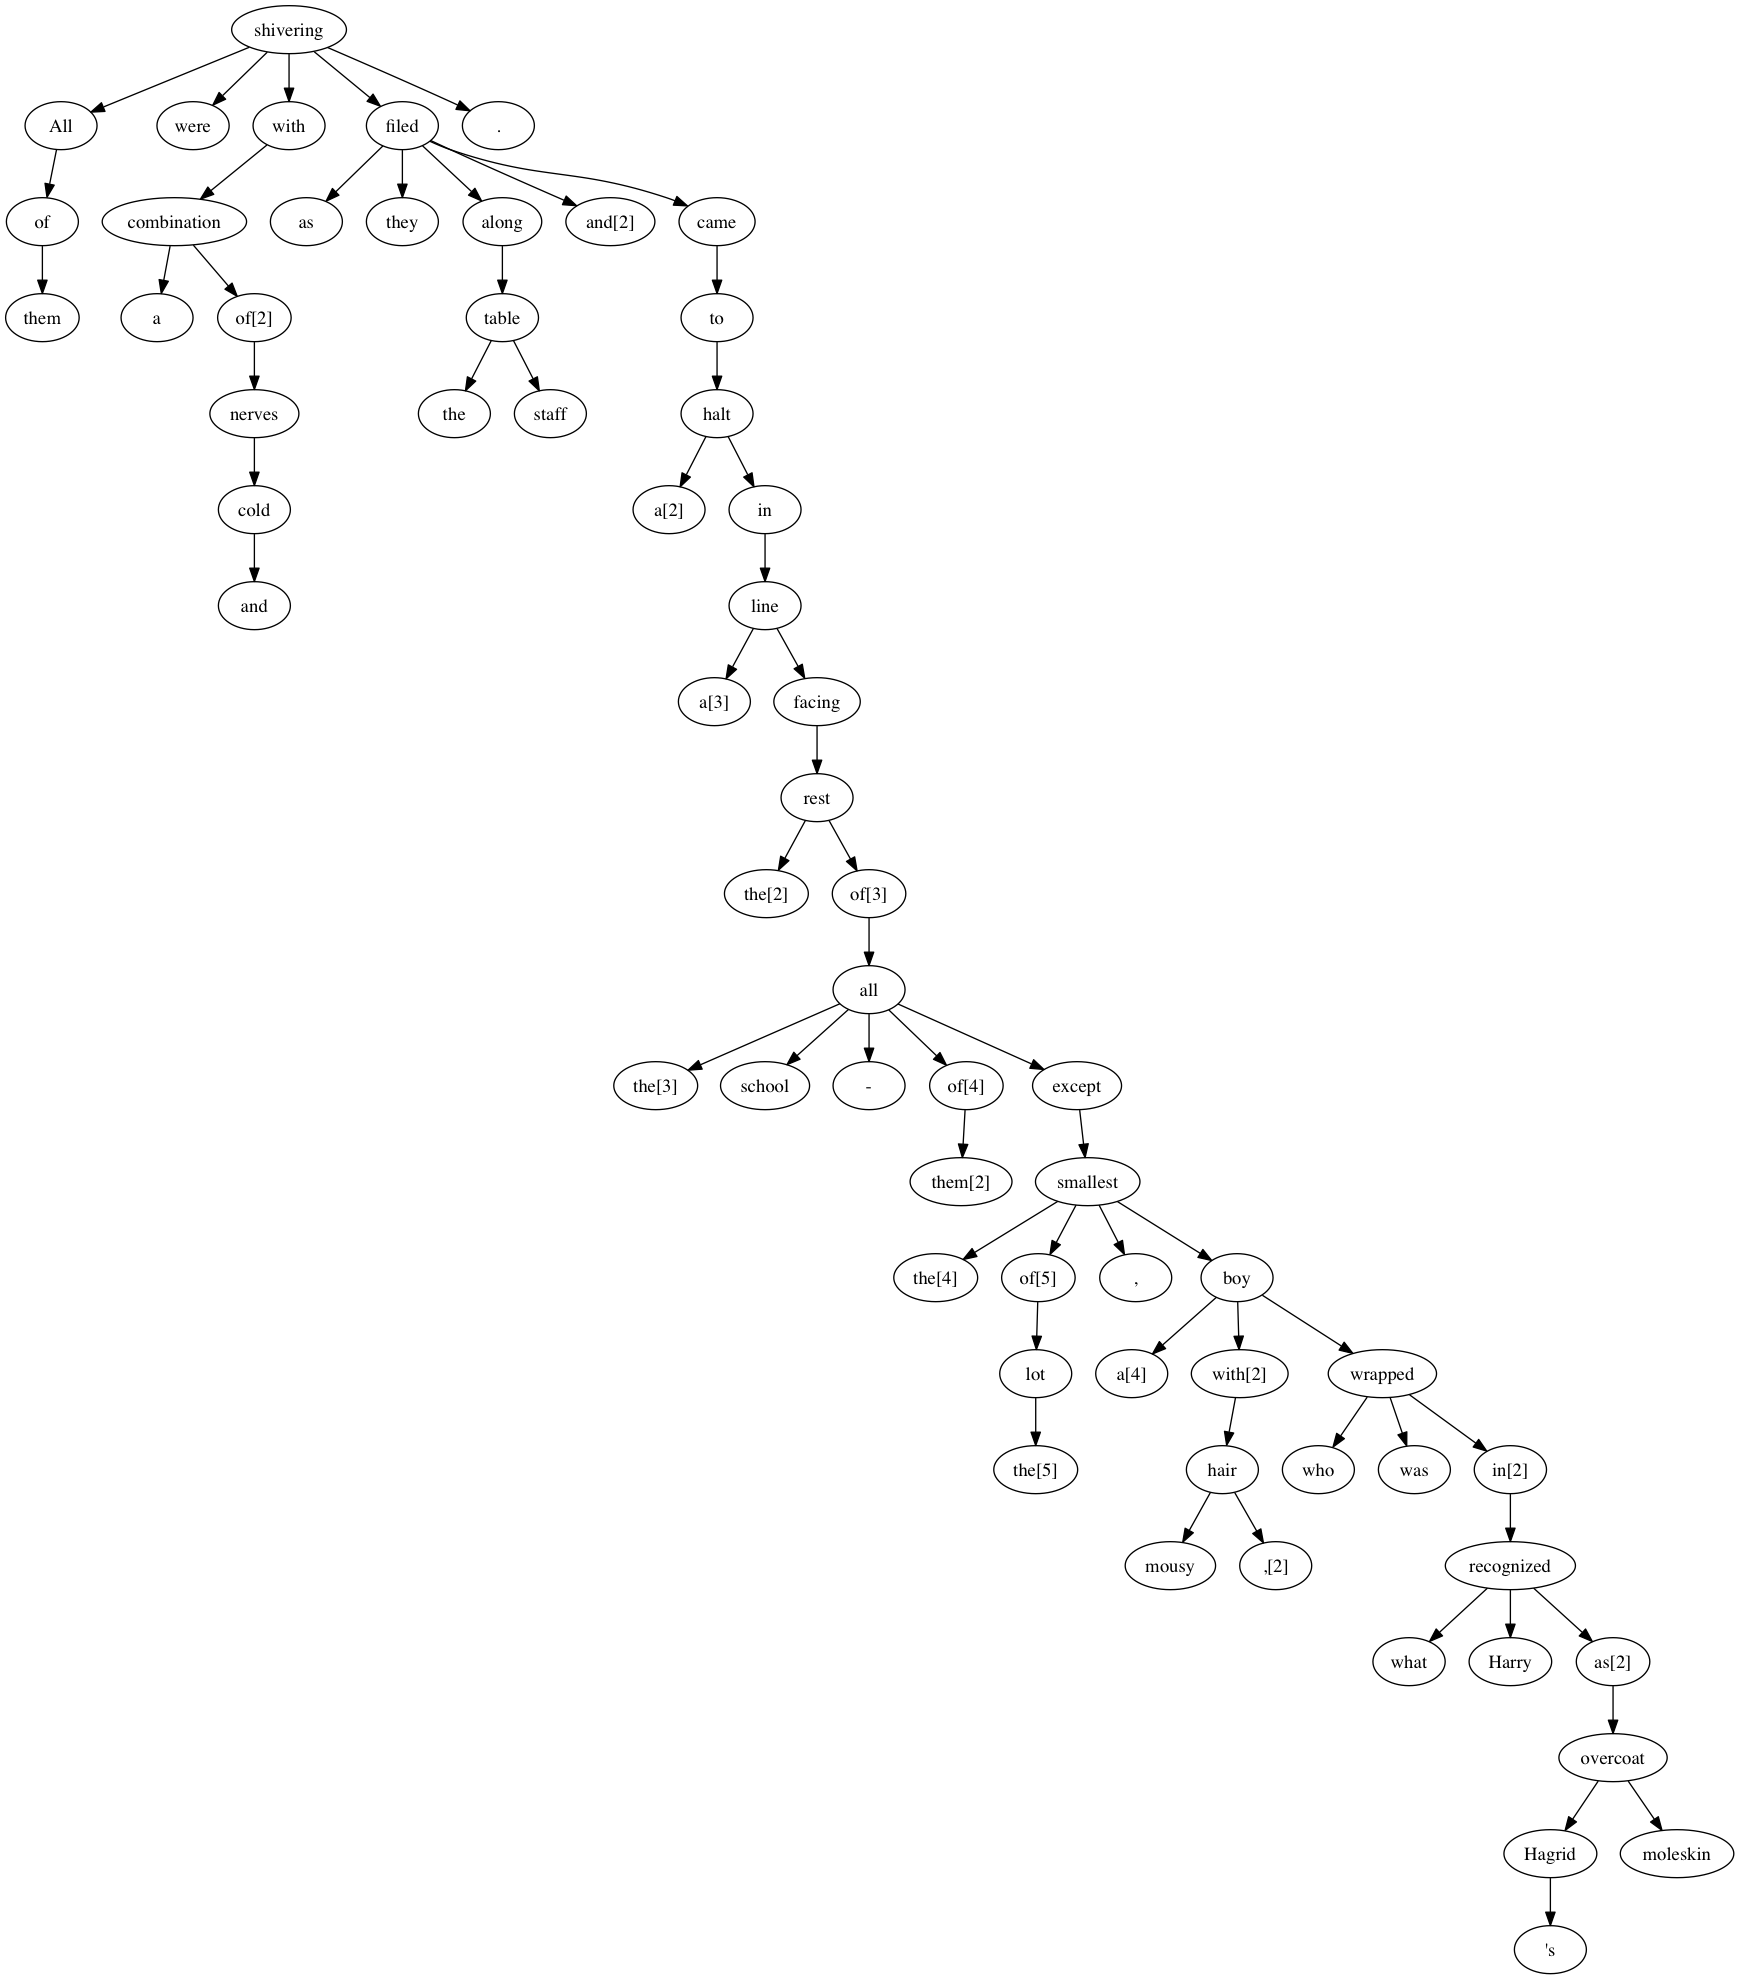

In [59]:
_, maxsentnum, maxbooknum = sent_depths.ix[sent_depths.Depth.idxmax()]
[sent] = list(it.islice(bktksall[maxbooknum].sents, int(maxsentnum),
                        int(maxsentnum + 1)))
print(sent)
show_graph(build_graph(sent))

#### Longest sentences
These seem to reveal some parsing issues, where a sequence of quick dialogue or lyrics are interpreted as a single sentence. Here are the two longest ones, filtering the number of newlines:

In [60]:
for s in [sent for _, bk in sorted(bktksall.items())
          for sent in bk.sents if (spanlen(sent) > 150) and
          (Counter(sent.string).get('\n', 0) < 3)]:
    print(Counter(s.string).get('\n', 0))
    print(s, end='\n\n=======\n\n')

1
"Let's get undercover before we talk you through it."
Harry led them all back into the kitchen where, laughing and chattering, they settled on chairs, sat themselves upon Aunt Petunia's gleaming work surfaces, or leaned up against her spotless appliances: Ron, long and lanky; Hermione, her bushy hair tied back in a long plait; Fred and George, grinning identically; Bill, badly scarred and long-haired; Mr. Weasley, kind-faced, balding, his spectacles a little awry; Mad-Eye, battle-worn, one-legged, his bright blue magical eye whizzing in its socket; Tonks, whose short hair was her favorite shade of bright pink; Lupin, grayer, more lined; Fleur, slender and beautiful, with her long silvery blonde hair; Kingsley, bald, black, broad-shouldered; Hagrid, with his wild hair and beard, standing hunchbacked to avoid hitting his head on the ceiling; and Mundungus Fletcher, small, dirty, and hangdog, with his droopy basset hound's eyes and matted hair.


2
Somehow he walled it all up in his min

In [62]:
!date

Sun Jan 17 18:53:11 EST 2016
